In [1]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

#### Load the data

In [2]:
data = np.load('data/citeseer.npz')
print(data.files)
adj_indices = data['adj_indices']
adj_indptr = data['adj_indptr']
adj_data = data['adj_data']
adj_shape = data['adj_shape']
_z_obs = data['labels']
conset = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape)
_A_obs = conset + conset.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]


['attr_indptr', 'attr_text', 'attr_data', 'idx_to_node', 'labels', 'idx_to_attr', 'adj_indptr', 'adj_indices', 'attr_indices', 'adj_shape', 'attr_shape', 'adj_data']
Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
rw_len = 16
batch_size = 128

In [7]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [8]:
walker.walk().__next__()

array([[1382, 1388, 1381, ..., 1594, 1481, 1482],
       [ 893, 1110,  769, ..., 1006, 1005,  639],
       [ 613,  610,  611, ...,  782,  719, 1227],
       ...,
       [ 866,  629, 1652, ...,  629, 1022,  629],
       [1529, 1381, 1485, ..., 1489, 1488, 1489],
       [1167,  159, 1118, ...,  470,  553,  470]], dtype=int64)

#### Create our NetGAN model

In [9]:
tf.reset_default_graph()
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=1, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=128, W_down_generator_size=128, noise_dim=2,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

W0712 18:42:11.286649  5760 deprecation_wrapper.py:119] From F:\netgan\netgan-master\netgan\netgan.py:108: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0712 18:42:11.693850  5760 deprecation_wrapper.py:119] From F:\netgan\netgan-master\netgan\netgan.py:116: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 18:42:11.753596  5760 deprecation_wrapper.py:119] From F:\netgan\netgan-master\netgan\netgan.py:119: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0712 18:42:15.182028  5760 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0

#### Define the stopping criterion

In [10]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [11]:
eval_every = 2000
plot_every = 2000

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_2.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****


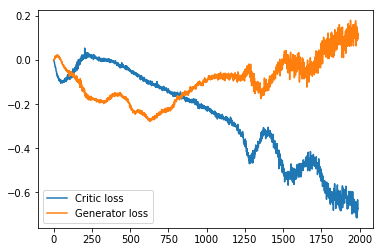

**** Iter 2000   Val ROC 0.750, AP: 0.751, EO 0.011 ****
2500   /200000   training iterations, took 398 seconds so far...


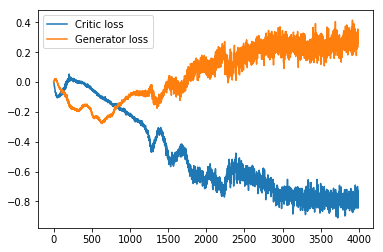

**** Iter 4000   Val ROC 0.892, AP: 0.906, EO 0.035 ****
5000   /200000   training iterations, took 797 seconds so far...


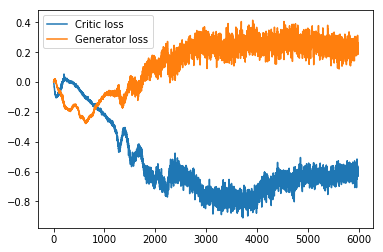

**** Iter 6000   Val ROC 0.924, AP: 0.934, EO 0.065 ****
7500   /200000   training iterations, took 1195 seconds so far...


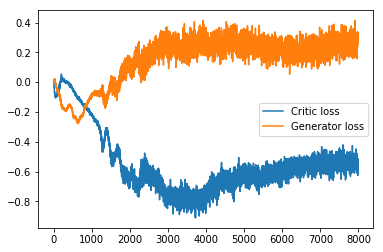

**** Iter 8000   Val ROC 0.948, AP: 0.955, EO 0.111 ****


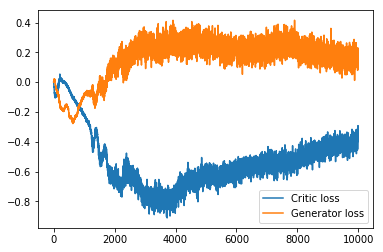

10000  /200000   training iterations, took 1584 seconds so far...
**** Iter 10000  Val ROC 0.938, AP: 0.941, EO 0.180 ****


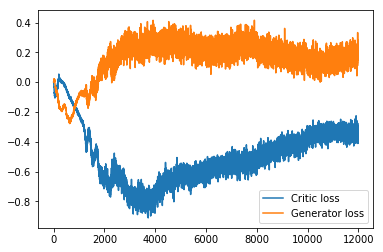

**** Iter 12000  Val ROC 0.944, AP: 0.948, EO 0.243 ****
12500  /200000   training iterations, took 2024 seconds so far...


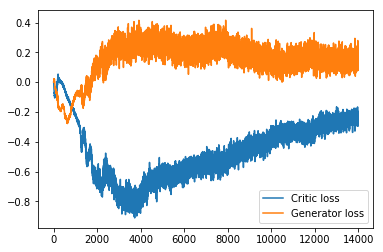

**** Iter 14000  Val ROC 0.945, AP: 0.950, EO 0.308 ****
15000  /200000   training iterations, took 2404 seconds so far...


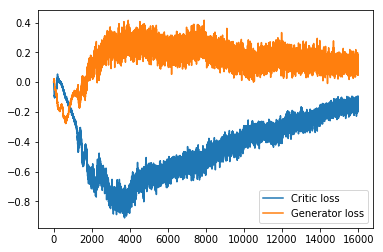

**** Iter 16000  Val ROC 0.956, AP: 0.959, EO 0.360 ****
17500  /200000   training iterations, took 2779 seconds so far...


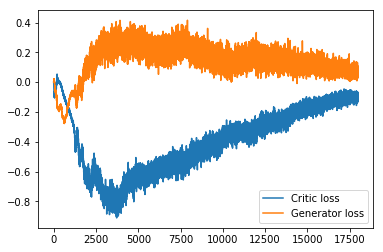

**** Iter 18000  Val ROC 0.953, AP: 0.956, EO 0.416 ****


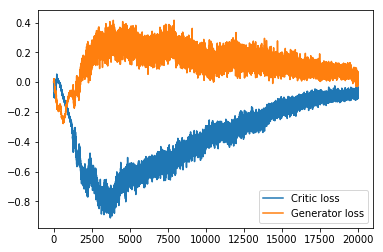

20000  /200000   training iterations, took 3152 seconds so far...
**** Iter 20000  Val ROC 0.941, AP: 0.947, EO 0.479 ****


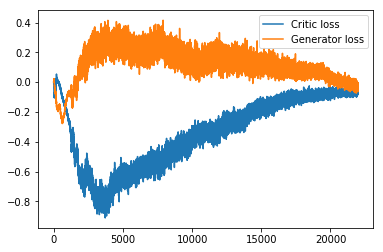

**** Iter 22000  Val ROC 0.943, AP: 0.947, EO 0.555 ****
22500  /200000   training iterations, took 3558 seconds so far...


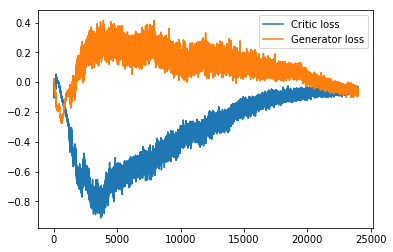

**** Iter 24000  Val ROC 0.942, AP: 0.944, EO 0.615 ****
25000  /200000   training iterations, took 3932 seconds so far...


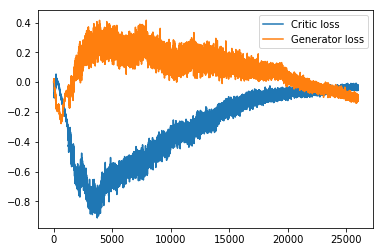

**** Iter 26000  Val ROC 0.921, AP: 0.924, EO 0.687 ****
27500  /200000   training iterations, took 4304 seconds so far...


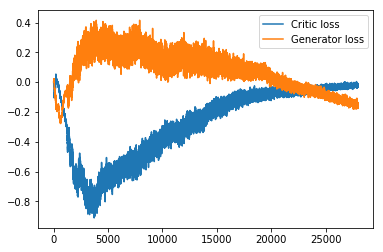

**** Iter 28000  Val ROC 0.924, AP: 0.926, EO 0.745 ****


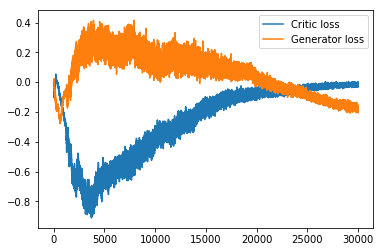

30000  /200000   training iterations, took 4701 seconds so far...
**** Iter 30000  Val ROC 0.908, AP: 0.911, EO 0.768 ****


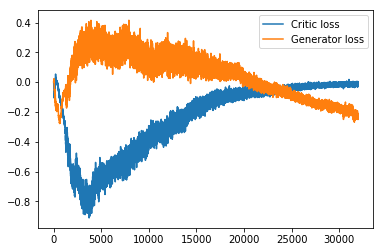

**** Iter 32000  Val ROC 0.906, AP: 0.909, EO 0.784 ****
32500  /200000   training iterations, took 5113 seconds so far...


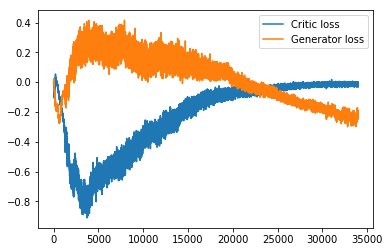

**** Iter 34000  Val ROC 0.892, AP: 0.895, EO 0.781 ****
35000  /200000   training iterations, took 5483 seconds so far...


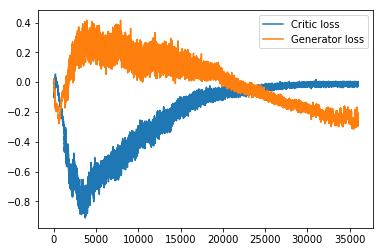

**** Iter 36000  Val ROC 0.901, AP: 0.902, EO 0.795 ****
37500  /200000   training iterations, took 5854 seconds so far...


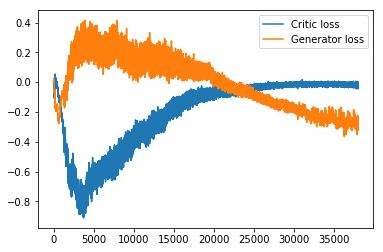

**** Iter 38000  Val ROC 0.897, AP: 0.899, EO 0.792 ****


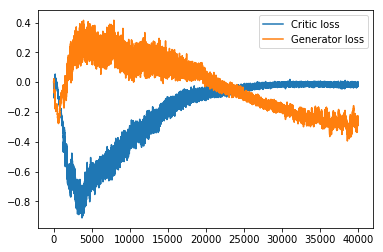

40000  /200000   training iterations, took 6227 seconds so far...
**** Iter 40000  Val ROC 0.898, AP: 0.900, EO 0.793 ****


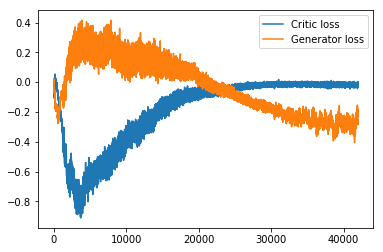

**** Iter 42000  Val ROC 0.907, AP: 0.910, EO 0.804 ****
42500  /200000   training iterations, took 6662 seconds so far...


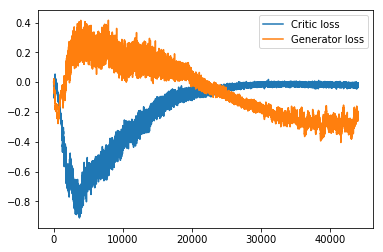

**** Iter 44000  Val ROC 0.889, AP: 0.893, EO 0.795 ****
45000  /200000   training iterations, took 7038 seconds so far...


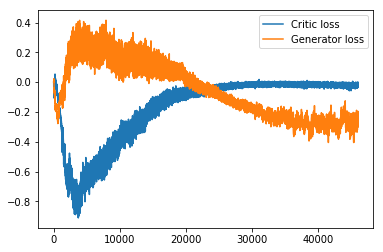

**** Iter 46000  Val ROC 0.895, AP: 0.899, EO 0.796 ****
47500  /200000   training iterations, took 7415 seconds so far...


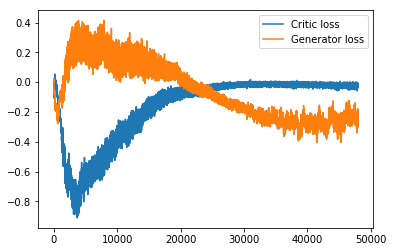

**** Iter 48000  Val ROC 0.897, AP: 0.901, EO 0.793 ****


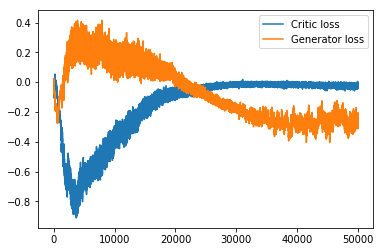

50000  /200000   training iterations, took 7805 seconds so far...
**** Iter 50000  Val ROC 0.897, AP: 0.900, EO 0.795 ****


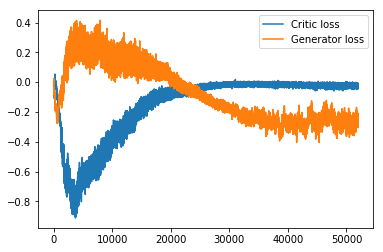

**** Iter 52000  Val ROC 0.893, AP: 0.897, EO 0.792 ****
52500  /200000   training iterations, took 8253 seconds so far...


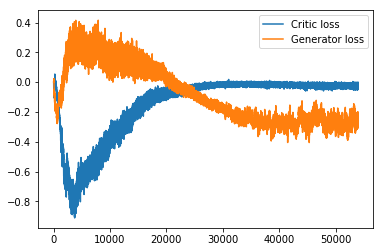

**** Iter 54000  Val ROC 0.903, AP: 0.905, EO 0.799 ****
55000  /200000   training iterations, took 8659 seconds so far...


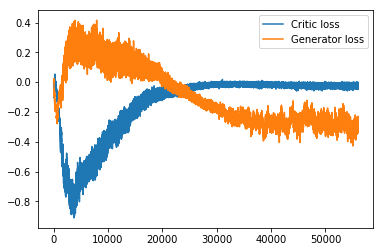

**** Iter 56000  Val ROC 0.900, AP: 0.902, EO 0.800 ****
**** EARLY STOPPING AFTER 56000 ITERATIONS ****
**** Training completed after 56000 iterations. ****


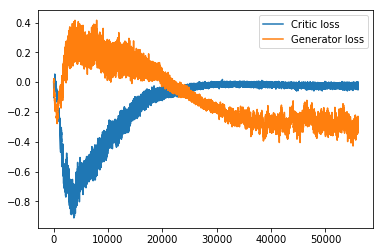

In [29]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=20, max_iters=200000)

In [ ]:
log_dict.keys()

In [ ]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

In [ ]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [57]:
noise_tf = tf.placeholder(tf.float32, shape=[1000, netgan.noise_dim])

In [58]:
saver = tf.train.Saver()
saver.restore(netgan.session, "snapshots/model_best_2.ckpt")

sample_many = netgan.generate_discrete(1000, reuse=True, z=noise_tf)

In [59]:
from scipy.special import ndtri

In [60]:
all_walks = []
all_noise = []
before = time.time()
iterations =   3000 #29144
for it in range(iterations):
    noise = np.random.uniform(low=0, high=1, size=[1000, netgan.noise_dim])
    gaussian_noise = ndtri(noise)
    walks = sample_many.eval(feed_dict={noise_tf: gaussian_noise, netgan.tau:0.5})
    all_walks.extend(list(walks))
    all_noise.extend(list(noise))
    if (it+1) % 100 == 0:
        elapsed = time.time() - before
        print("{}/{} took {}, eta {}".format(it+1, iterations, elapsed, iterations/(it+1)*elapsed - elapsed))

np.savez_compressed("walks.npz", 
                    walks = np.array(all_walks).astype("uint16"),
                    noise = np.array(all_noise))

100/3000 took 4.378498554229736, eta 126.97645807266235
200/3000 took 7.7754106521606445, eta 108.85574913024902
300/3000 took 11.166348218917847, eta 100.49713397026062
400/3000 took 14.570229768753052, eta 94.70649349689484
500/3000 took 18.011013507843018, eta 90.05506753921509
600/3000 took 21.434854745864868, eta 85.73941898345947
700/3000 took 24.87166476249695, eta 81.72118421963283
800/3000 took 28.27955389022827, eta 77.76877319812775
900/3000 took 31.76722764968872, eta 74.12353118260702
1000/3000 took 35.18807911872864, eta 70.37615823745728
1100/3000 took 38.61591386795044, eta 66.70021486282347
1200/3000 took 42.03280830383301, eta 63.04921245574951
1300/3000 took 45.44369053840637, eta 59.42636455022371
1400/3000 took 48.86052227020264, eta 55.84059688023159
1500/3000 took 52.279377698898315, eta 52.279377698898315
1600/3000 took 55.6833074092865, eta 48.72289398312569
1700/3000 took 59.10515999794006, eta 45.19806352783651
1800/3000 took 62.512017250061035, eta 41.674678

In [61]:
walkes = np.load('walks.npz')
print(walkes.files)
all_walks = np.array(walkes['walks'])
all_noise = np.array(walkes['noise'])

['walks', 'noise']


In [62]:
all_walks.shape

(3000000, 16)

In [7]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))

## Latent space heatmaps

In [64]:
n_bins = 20
bins = np.arange(0, 1, 1/n_bins)

In [65]:
noise_bins = np.floor(all_noise /  (1/n_bins)).astype('int')

### Here we generate a graph from the random walks in each bin and measure their properties

In [66]:
graphs_bins = [[None for i in range(n_bins)] for j in range(n_bins)]
matrices = [[None for i in range(n_bins)] for j in range(n_bins)]
statistics = [[None for i in range(n_bins)] for j in range(n_bins)]
begin = time.time()
it = 0

for x1 in range(n_bins):
    for x2 in range(n_bins):
        it += 1
        graphs_bins[x1][x2] = utils.score_matrix_from_random_walks(all_walks[np.where((noise_bins[:,0] == x1) &
                                                                       (noise_bins[:,1] == x2))], netgan.N)
        graph_select = utils.graph_from_scores(graphs_bins[x1][x2], A_select.sum())
        matrices[x1][x2] = sp.coo_matrix(graph_select)
        statistics[x1][x2] = utils.compute_graph_statistics(graph_select)
        elapsed = time.time() - begin
    print("{}/{} took {:.2f}, eta {:.2f}".format(it, n_bins**2, elapsed, (n_bins**2)/(it)*elapsed - elapsed))
    

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

20/400 took 40.59, eta 771.28


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


40/400 took 80.24, eta 722.15


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

60/400 took 119.75, eta 678.58


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

80/400 took 159.98, eta 639.91


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


100/400 took 200.17, eta 600.52


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


120/400 took 240.31, eta 560.72


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

140/400 took 280.97, eta 521.80


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

160/400 took 321.39, eta 482.09


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

180/400 took 361.57, eta 441.91


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

200/400 took 402.64, eta 402.64


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

220/400 took 444.77, eta 363.91


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


240/400 took 485.91, eta 323.94


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


260/400 took 527.07, eta 283.81


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

280/400 took 567.48, eta 243.21


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


300/400 took 607.69, eta 202.56


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

320/400 took 648.77, eta 162.19


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

340/400 took 689.30, eta 121.64


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

360/400 took 730.63, eta 81.18


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

380/400 took 771.16, eta 40.59


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

400/400 took 811.72, eta 0.00


In [67]:
ks = list(statistics[0][0].keys())
statistics_dict = {k: np.array([y[k] for x in statistics for y in x]).reshape((n_bins, n_bins)) for k in ks}

In [68]:
first_nodes = all_walks[:,0]
degrees = A_select.sum(0).A1
unique, indices, counts = np.unique(first_nodes, return_counts=True, return_inverse=True)

In [69]:
first_node_degrees = degrees[first_nodes]

In [70]:
from scipy.stats import entropy

### Here we compute some statistics of the random walks themselves

In [71]:
entropies = np.zeros([n_bins, n_bins])
one_comm = np.zeros([n_bins, n_bins])
unique_nodes = np.zeros([n_bins, n_bins])
first_node_comm = np.zeros([n_bins, n_bins])
for x in range(n_bins):
    print(x)
    for y in range(n_bins):
        sel = all_walks[(noise_bins[:,0] == x) & (noise_bins[:,1] == y),:]
        ons = np.ones_like(sel)
        first_node_communities = ons * np.expand_dims(_z_obs[sel[:,0]],1)
        first_node_comm[x,y] = np.mean(_z_obs[sel] == first_node_communities)
        
        unique_firstnodes = np.unique(sel[:,0], return_counts=True)[1]
        entr = entropy(unique_firstnodes) / np.log(len(unique_firstnodes))
        entropies[x, y] = entr
        
        communities = _z_obs[sel]
        share_one_community = (np.std(communities, axis=1) == 0).mean()
        one_comm[x,y] = share_one_community
        unique_nodes[x,y] = np.mean(list(map(len,(map(set,(map(tuple, sel)))))))
        
statistics_dict['unique_nodes'] = np.array(unique_nodes)
statistics_dict['one_community'] = np.array(one_comm)
statistics_dict['first_node_entropy'] = np.array(entropies)
statistics_dict['first_node_community'] = np.array(first_node_comm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [72]:
statistics_dict['claw_count'] = np.log(statistics_dict['claw_count'])

In [73]:
statistics_dict['avg_starting_degree'] = np.array([np.mean(first_node_degrees[(noise_bins[:,0] == x) & (noise_bins[:,1] == y) ])
       for x in range(n_bins) for y in range(n_bins)]).reshape((n_bins, n_bins))

Store the results to disk so that we don't have to run all of this again

In [74]:
np.savez_compressed('intermediate/results_{}x{}.npz'.format(n_bins, n_bins), 
                    graphs = matrices,
                    statistics = statistics_dict)

## Load statistics from file (start here if you just want to run the visualization)

### Uncomment the following to load from disk

In [75]:
#results = np.load('intermediate/results_{}x{}.npz'.format(n_bins, n_bins))
#matrices = results['graphs']
#statistics_dict = results['statistics'].item()

In [76]:
plt.rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
def heatmap(scores, ax, title=None, cbar=True):  
    pl = ax.imshow(np.array(scores), cmap='inferno', interpolation='nearest', extent=[0,1,0,1])

    if title is not None:
        plt.title(title, fontsize=15)

    ax.set_xticks([0,1])
    ax.get_yaxis().set_tick_params(labelsize=15)
    ax.get_xaxis().set_tick_params(labelsize=15)
    ax.set_yticks([0,1])
    ax.set_xlabel(r'$\Phi(\mathbf{z}_1)$', labelpad=-13, fontsize=20)
    ax.set_ylabel(r'$\Phi(\mathbf{z}_2)$', labelpad=-11, fontsize=20)
    
    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cb = plt.colorbar(pl, cax=cax)


In [77]:
eval_keys = ['d_max', 'assortativity', 'triangle_count', 'wedge_count', 'power_law_exp',
             'rel_edge_distr_entropy', 'LCC', 'claw_count', 'gini', 'unique_nodes', 'one_community',
             'first_node_entropy','first_node_community', 'avg_starting_degree', 'cpl']

display_titles = {'d_max': 'Max. degree', 'assortativity': 'Assortativity', 'triangle_count': 'Triangle count',
                  'wedge_count': 'Wedge count', 'power_law_exp': 'Power law exponent',
                  'rel_edge_distr_entropy':'Rel. edge distribution entropy', 'LCC': 'Largest connected component',
                  'claw_count': 'Claw count', 'gini': 'Gini coefficient', 
                 'unique_nodes': 'Unique nodes per walk', 'one_community': 'Walks in single community',
                  'first_node_entropy': 'Entropy of starting nodes', 'first_node_community': 'Share nodes in starting comm.',
                 'avg_starting_degree': 'Avg. degree of first node', 'cpl': 'Characteristic path length'}

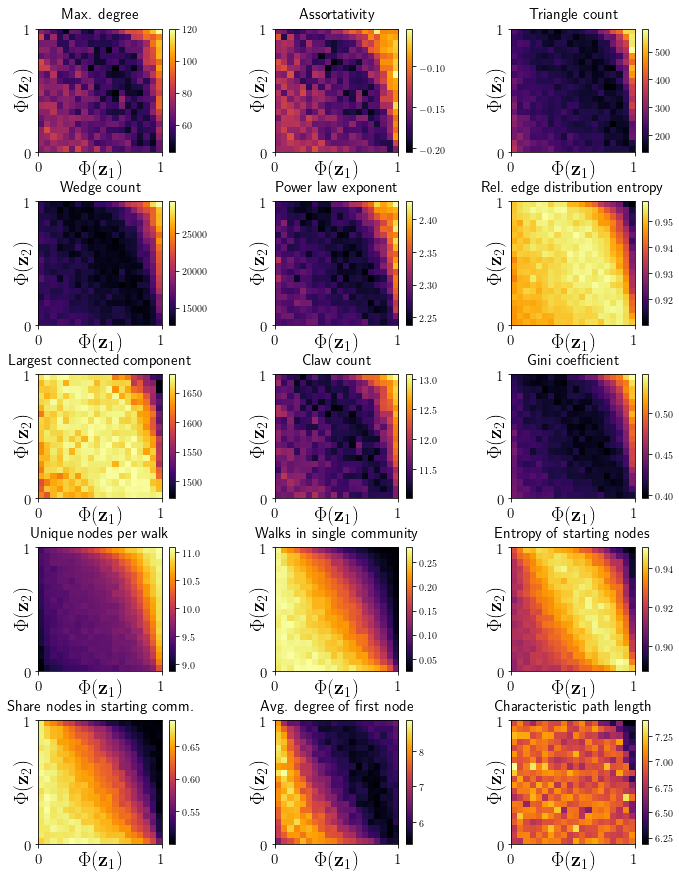

In [135]:
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams['axes.titlepad'] = 10 
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

n_cols = 3
n_rows = int(np.ceil(len(display_titles)/n_cols))
fig=plt.figure(figsize=(4*n_cols,3*n_rows))

gs = gridspec.GridSpec(n_rows, n_cols, hspace=0.4)

for ix,key in enumerate(eval_keys):
    ax = plt.subplot(gs[ix // n_cols, ix % n_cols])
    vals = statistics_dict[key]
    heatmap(vals, ax, cbar=True, title=display_titles[key])

plt.savefig("intermediate/heatmaps.png", dpi=150)
plt.show()

## Community structure plots

In [79]:
n_bins_community = 10
bins_community = np.arange(0, 1, 1/n_bins_community)

In [80]:
noise_bins_community = np.floor(all_noise /  (1/n_bins_community)).astype('int')

In [81]:
graphs = [[None for i in range(n_bins_community)] for j in range(n_bins_community)]
begin = time.time()
it = 0

for x1 in range(n_bins_community):
    for x2 in range(n_bins_community):
        it += 1
        scores = utils.score_matrix_from_random_walks(all_walks[np.where((noise_bins[:,0] == x1) &
                                                                       (noise_bins[:,1] == x2))], netgan.N)
        graph_select = utils.graph_from_scores(scores, A_select.sum())
        graphs[x1][x2] = sp.coo_matrix(graph_select)
        elapsed = time.time() - begin
    print("{}/{} took {:.2f}, eta {:.2f}".format(it, n_bins_community**2, elapsed, (n_bins_community**2)/(it)*elapsed - elapsed))

10/100 took 3.80, eta 34.21
20/100 took 7.20, eta 28.81
30/100 took 10.63, eta 24.81
40/100 took 14.10, eta 21.15
50/100 took 17.54, eta 17.54
60/100 took 21.07, eta 14.05
70/100 took 24.53, eta 10.51
80/100 took 27.97, eta 6.99
90/100 took 31.42, eta 3.49
100/100 took 34.90, eta 0.00


In [82]:
all_scores = utils.score_matrix_from_random_walks(all_walks, netgan.N)
all_graph_select = utils.graph_from_scores(sp.coo_matrix(all_scores), A_select.sum())

In [83]:
np.savez_compressed('intermediate/results_communities_{}x{}.npz'.format(n_bins_community, n_bins_community), 
                    graphs = graphs,
                    all_walks_graph = sp.csr_matrix(all_graph_select))

## Load statistics from file (start here if you just want to run the visualization)

### Uncomment the following to load from disk

In [84]:
#n_bins_community = 10
#results = np.load('intermediate/results_communities_{}x{}.npz'.format(noise_bins_community, noise_bins_community))
#graphs = results['graphs']
#all_graph_select = results['all_walks_graph'].item()

In [85]:
from collections import Counter

In [86]:
n_communities = _z_obs.max()+1

In [87]:
distrs = []
for x in range(len(graphs)):
    for y in range(len(graphs[x])):
        graph_internal = graphs[x][y]
        edges = np.transpose(graph_internal.nonzero())
        edges_communities = _z_obs[edges]
        blocks = np.zeros((n_communities, n_communities))
        blocks[edges_communities[:,0], edges_communities[:,1]] 
        tpls = list(map(tuple, edges_communities))
        counts = Counter(tpls)
        for k,v in counts.items():
            blocks[k] = v
        distrs.append(blocks)

In [88]:
distrs = np.array(distrs).reshape([n_bins_community, n_bins_community,n_communities, n_communities])

range(0, 6)
  (0, 168)	1.0
  (0, 353)	1.0
  (0, 399)	1.0
  (0, 573)	1.0
  (0, 583)	1.0
  (1, 2)	1.0
  (2, 1)	1.0
  (2, 44)	1.0
  (2, 70)	1.0
  (2, 286)	1.0
  (3, 4)	1.0
  (4, 3)	1.0
  (4, 7)	1.0
  (4, 59)	1.0
  (4, 91)	1.0
  (4, 124)	1.0
  (4, 182)	1.0
  (4, 183)	1.0
  (4, 187)	1.0
  (4, 205)	1.0
  (4, 206)	1.0
  (4, 207)	1.0
  (4, 215)	1.0
  (4, 244)	1.0
  (4, 252)	1.0
  :	:
  (1662, 884)	1.0
  (1663, 1615)	1.0
  (1664, 1579)	1.0
  (1665, 1455)	1.0
  (1666, 1431)	1.0
  (1666, 1544)	1.0
  (1667, 1433)	1.0
  (1668, 1441)	1.0
  (1668, 1442)	1.0
  (1669, 1487)	1.0
  (1670, 1484)	1.0
  (1671, 1431)	1.0
  (1672, 1381)	1.0
  (1673, 1446)	1.0
  (1674, 1441)	1.0
  (1674, 1486)	1.0
  (1675, 1449)	1.0
  (1675, 1450)	1.0
  (1675, 1493)	1.0
  (1676, 1511)	1.0
  (1677, 1586)	1.0
  (1678, 1466)	1.0
  (1679, 1474)	1.0
  (1679, 1494)	1.0
  (1680, 1443)	1.0
0
(4230,)


IndexError: index (3512) out of range

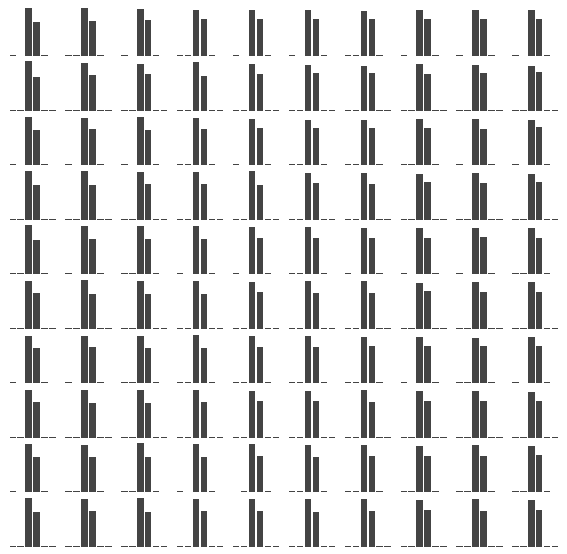

In [113]:
import matplotlib.patches as patches
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
rcParams['axes.titlepad'] = 10 
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

font = {'family': 'serif',
        'weight': 'normal',
        'size': 28,
        'ha': 'center',
        'va': 'center'
        }

fig = plt.figure(figsize=(11, 10))
max_height = np.max(np.sum(distrs, axis=2))

# gridspec inside gridspec
outer_grid = gridspec.GridSpec(1, 2, wspace=0.02, hspace=0.0, width_ratios=[11, 1], bottom=0.13, left=0.13)

inner_grid_1 = gridspec.GridSpecFromSubplotSpec(n_bins_community, n_bins_community,
            subplot_spec=outer_grid[0], wspace=0.1, hspace=.1)

for x_ix in range(distrs.shape[0]):
    for y_ix in range(distrs.shape[1]):
        ax = plt.Subplot(fig, inner_grid_1[x_ix, y_ix])
        distr = distrs[x_ix][y_ix]
        plot_normal = ax.bar(np.arange(n_communities), np.sum(distr, axis=0), color='#444444')

        ax.set_xticks([])
        ax.set_yticks([])

        fig.add_subplot(ax)
        plt.ylim((0, max_height))
        plt.axis('off')


inner_grid_2 = gridspec.GridSpecFromSubplotSpec(n_bins_community, 1,
            subplot_spec=outer_grid[1], wspace=0.0, hspace=0.1)

# original graph
ax = plt.Subplot(fig, inner_grid_2[int(n_bins_community/2)-1, 0])
ax.patch.set_alpha(0.0)
distr = np.zeros([n_communities, n_communities])
graph_int = A_select
for i in range(n_communities):
    for j in range(n_communities):
        print(range(n_communities))
        print(A_select)
        print(i)
        print((_z_obs == i).shape)
        sel = A_select[_z_obs == i]
        sel = sel[:,_z_obs == j]
        distr[i,j] = sel.sum()
plot_orig = ax.bar(np.arange(n_communities), np.sum(distr, axis=0),color='#386cb0')
fig.add_subplot(ax)
plt.ylim((0, max_height))
plt.axis('off')

# graph from all regions of z
ax = plt.Subplot(fig, inner_grid_2[int(n_bins_community/2), 0])
ax.patch.set_alpha(0.0)
distr = np.zeros([n_communities, n_communities])
graph_int = all_graph_select
for i in range(n_communities):
    for j in range(n_communities):
        sel = all_graph_select[_z_obs ==i]
        sel = sel[:,_z_obs == j]
        distr[i,j] = sel.sum()
plot_all_sample = ax.bar(np.arange(n_communities), np.sum(distr, axis=0),color='#999999')
fig.add_subplot(ax)
plt.ylim((0, max_height))
plt.axis('off')


all_axes = fig.get_axes()
    
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
plt.tick_params(axis='both', which='major', labelsize=20)
text_left = plt.text(-0.1, 0.45, r'$\Phi(\mathbf{z}_2)$', fontdict=font, rotation=90)
text_bot = plt.text(0.5, -0.1, r'$\Phi(\mathbf{z}_1)$', fontdict=font, rotation=0)
plt.xlim((-.01, 1 + 1/n_bins_community))
plt.ylim((-.015, .9785))
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
plt.title("Community distributions for subregions of $\mathbf{z}$", fontdict=font)
lgd = plt.legend([plot_orig, plot_all_sample, plot_normal],
           ["Original community\ndistribution",
            "Community distribution on\nall $\mathbf{z}$ regions",
            "Community distribution on\n$\mathbf{z}$ subregions"],
           bbox_to_anchor=(0.93, 0.3), labelspacing=.5, fontsize=16)
ax.plot([-0.006,-.006],[-.011,.95] , 'k-', lw=1)
ax.plot([.999,.999],[-.011,.95] , 'k--', lw=1)
ax.plot([-0.006,.999],[-.011,-.011] , 'k-', lw=1)

#plt.savefig( "{}_community_distr_{}x{}.pdf".format('cora', n_bins_community, n_bins_community),
#           bbox_extra_artists=( text_left, text_bot), bbox_inches='tight')
plt.show()